# Introduction to the Laser Learning Environment `World`
This notebook goes through the `World` class and how to use it. The `World` class is meant to be used for low-level control of LLE, as opposed to the `LLE` class, meant for high-level control and multi-agent reinforcement learning.

## 1. How to install
Enter the following instructions in a terminal:

- `pip install laser-learning-environment`
- `pip install matplotlib`

This installs the Laser Learning Environment and its dependencies. After this operation, you should be able to import `lle` in this notebook: 

In [9]:
import lle

If it works, you are ready to go !

In order to display the environment, we will use some functions from the package `matplotlib`. Some other available examples use the package `cv2`. Change the variable $display$ to $False$ if you do not want this notebook to display the boards.

In [10]:
from lle import World
import matplotlib.pyplot as plt
DISPLAY = True

def display_world(w: World):
    if DISPLAY:
        plt.imshow(w.get_image())
        plt.axis("off")
        plt.show()

## 2. Using LLE
### 2.1 Predefined levels
There exist 6 predefined levels that you can directly access with `World.level(<level>)`.

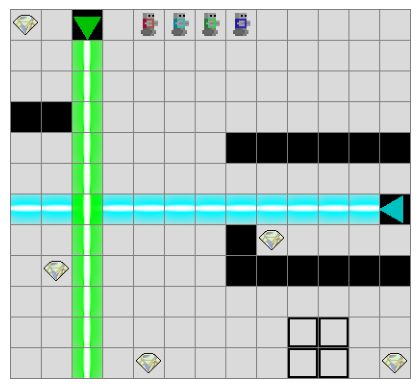

In [12]:
world = World.level(5)
display_world(world)

### 2.2 Create a board
LLE works with files that define the environment. The cases are represented with characters in a quite intuitive manner, that allows to easily create a new board.

| Character | Tile | Walkable | Comment |
------------|------|----------|---------|
| `.` | Floor | Yes | The most basic tile. |
| `@` | Wall  | No | A wall that blocks lasers. |
| `X` | Exit  | Yes | An exit tile. The agent can no longer move after reaching it. |
| `G` | Gem   | Yes | A gem to collect. |
| `S<n>` | Start | Yes | Start position of agent `n`. |
| `L<n><d>` | Laser source | No | Source of a laser of colour `n` (a number) beaming toward the direction `d` (N, S, E, W). |
| `V` | Void | Yes | A void tile. The agent dies if it walks on it |

#### 2.2.1 A simple empty board
Let us define a $6\times 5$ board with one agent and one destination. Note that some board configurations are invalid. For instance, there must be at least one exit tile per agent.

In [3]:
def get_empty_board(x, y):
    return [["." for _ in range(x)] for _ in range(y)]

def get_board_as_str(board):
    return "\n".join([" ".join(i) for i in board])

empty_board = get_empty_board(6, 5)
empty_board[0][0] = "S0"
empty_board[4][5] = "X"

board_str = get_board_as_str(empty_board)
world = World(board_str)

Let us now create a world from a text file by saving our board and then loading it into a world.

In [7]:
def save_board(board, filename):
    """Saves a board to a file in order to reload it later"""
    with open("./boards/" + filename, "w") as f:
        f.write(get_board_as_str(board))

save_board(empty_board, "empty")
empty = World.from_file("boards/empty")

And directly display it using `matplotlib.pyplot.imshow()`:

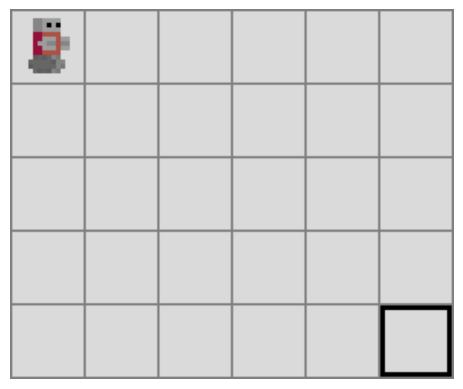

In [5]:
def display_world(w: World):
    if DISPLAY:
        plt.imshow(w.get_image())
        plt.axis('off')
        plt.show()

display_world(empty)

#### 2.2.2 Some more complex boards
We can use other characters as shown the the above table.

For example, with walls and voids tiles:

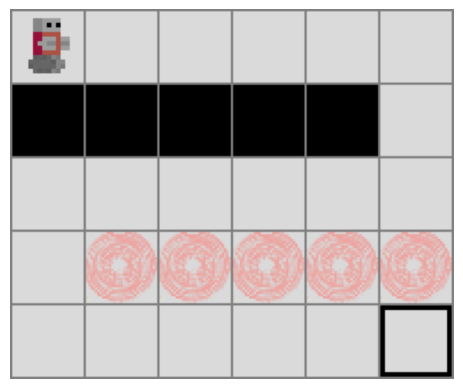

In [12]:
board_with_walls = get_empty_board(6, 5)
board_with_walls[0][0] = "S0"
board_with_walls[4][5] = "X"
board_with_walls[1] = ["@", "@", "@", "@", "@", "."]
board_with_walls[3] = [".", "V", "V", "V", "V", "V"]
save_board(board_with_walls, "walls")
with_walls = World.from_file("boards/walls")
display_world(with_walls)

Or with gems

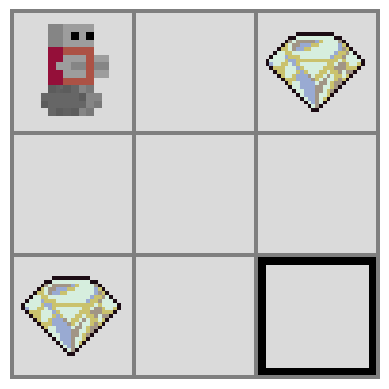

In [13]:
board_with_gems = get_empty_board(3, 3)
board_with_gems[0][0] = "S0"
board_with_gems[2][2] = "X"
board_with_gems[2][0] = "G"
board_with_gems[0][2] = "G"
save_board(board_with_gems, "gems")
with_gems = World.from_file("boards/gems")
display_world(with_gems)

Or, finally, with multiple agens:

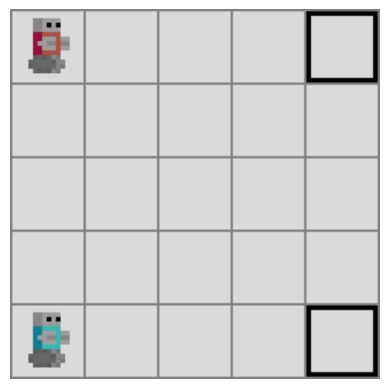

In [15]:
two_agents = get_empty_board(5, 5)
two_agents[0][0] = "S0"
two_agents[4][0] = "S1"
two_agents[4][4] = "X"
two_agents[0][4] = "X"
save_board(two_agents, "two_agents")
world_two_agents = World.from_file("boards/two_agents")
display_world(world_two_agents)

### 2.3. Playing with lasers
Lasers of a certain colors prevent agents of another color to pass. They can be blocked by agents of the same color. They form the basis of the constaints in the `LLE` framework.

Lasers have two characteristics:
- A number, which denotes the color of the laser
- An orientation (North, South, West, East)

As an example, a laser with color $0$ pointing to $East$ will be noted `L0E`.
Here is an example of a two-agents-two-lasers game.

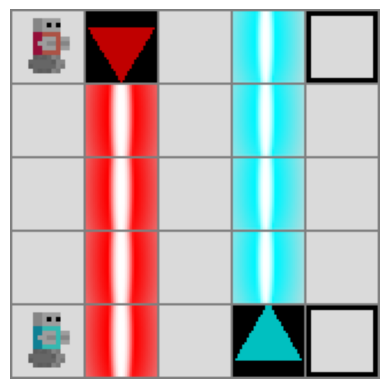

In [16]:
tatl = get_empty_board(5, 5)
tatl[0][0] = "S0"
tatl[4][0] = "S1"
tatl[4][4] = "X"
tatl[0][4] = "X"
tatl[0][1] = "L0S"
tatl[4][3] = "L1N"
save_board(tatl, "tatl")
world_tatl = World.from_file("boards/tatl")
display_world(world_tatl)

## 3. Conclusion and final examples
From now on, you should be familiar with the notion of board, agent, laser, gems, and wall. You should be able to create and display complex boards to represent complex problems.

Remember: the whole point of this environment is to make the agents reach the targets, without passing through lasers of the wrong colors, and to collect as many gems as possible, in a minimum amount of time.

This set-up describes a coordination problem.

For the coming sections, we will work on different boards. A first simple linear one:

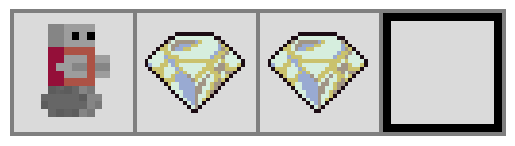

In [18]:
save_board([["S0", "G", "G", "X"]], "linear")
linear = World.from_file("boards/linear")
display_world(linear)

Then, a simple two-agents example:

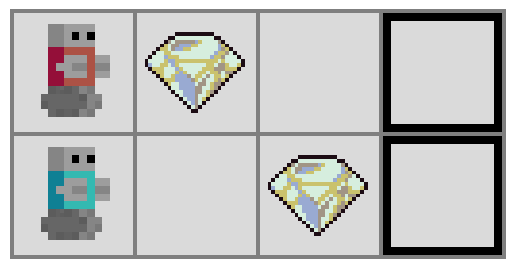

In [21]:
board_linear = """
S0 G . X
S1 . G X
"""
linear2 = World(board_linear)
display_world(linear2)

And finally a more complex example:

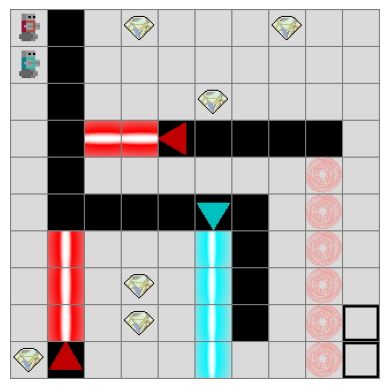

In [26]:
board = """
    S0  @   .  G  .   .  . G . .
    S1  @   .  .  .   .  . . . .
    .   @   .  .  .   G  . . . .
    .   @   .  . L0W  @  @ @ @ .
    .   @   .  .  .   .  . . V .
    .   @   @  @  @  L1S @ . V .
    .   .   .  .  .   .  @ . V .
    .   .   .  G  .   .  @ . V .
    .   .   .  G  .   .  @ . V X
    G  L0N  .  .  .   .  . . V X
"""
world = World(board)
display_world(world)

## 3 Playing with agents
### 3.1 Moving agents
To solve `LLE` problems, we have to move the agents across the board.
This can be done using `Action` objects, which can be either North, South, East, West, or STAY.

In [27]:
from lle import Action

For example, we can apply two times the action `EAST` on the first agent in the simple linear case to complete the problem. First, we `reset` the world, then we apply the function `step`. It takes a `list` as parameter, with as many `Actions` as there are agents to move. It returns the list of events that happened during the step. Events have different types, described in the EventType enum.

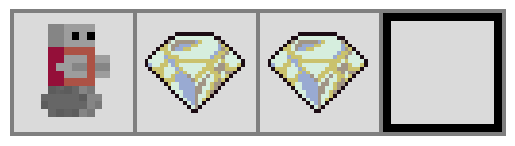

In [28]:
linear.reset()
display_world(linear)

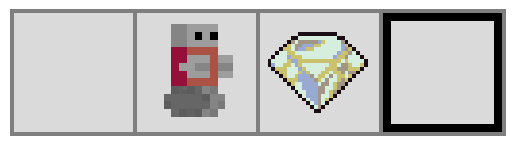

Events: [GemCollected, agent id: 0]


In [29]:
events = linear.step([Action.EAST])
display_world(linear)
print("Events:", events)

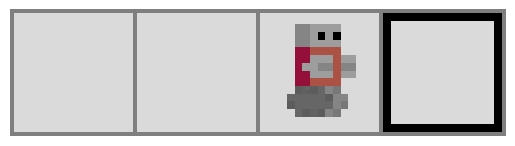

Events : [GemCollected, agent id: 0]


In [30]:
evnets = linear.step([Action.EAST])
display_world(linear)
print("Events :", events)

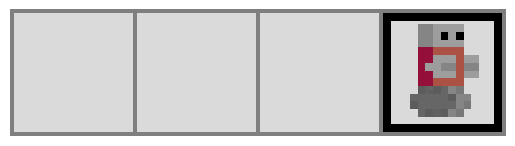

Events : [AgentExit, agent id: 0]


In [31]:
events = linear.step([Action.EAST])
display_world(linear)
print("Events :", events)

An agent that has reached an exit cannot move anymore and its only available action is `Action.STAY`.

In [32]:
print(linear.agents[0].has_arrived)
print("Available actions for agent 0:", linear.available_actions()[0])

True
Available actions for agent 0: [Stay]


### 3.2 Getting information about the environment

Some attributes of the world allow to get more information about the problem setting. We show some of them on this more complex example:

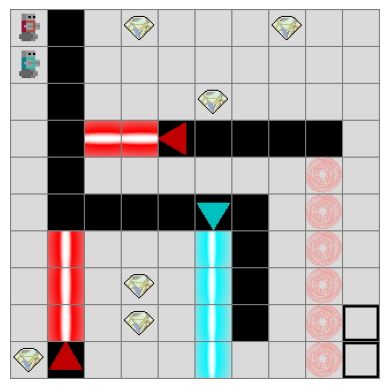

In [33]:
world.reset()
display_world(world)

In [34]:
world.reset()
print("Current state:", world.get_state())
print("Number of gems:", world.n_gems)
print("Number of collected gems:", world.gems_collected)
print("Position of the walls:", world.wall_pos)
print("Position of the voids:", world.void_pos)
print("Position of the exits:", world.exit_pos)
print("Position of the lasers:", world.lasers)
print("Position of the agents:", world.agents_positions)

Current state: WorldState(agent_positions=[(0, 0), (1, 0)], gems_collected=[false, false, false, false, false, false])
Number of gems: 6
Number of collected gems: 0
Position of the walls: [(0, 1), (1, 1), (2, 1), (3, 1), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (9, 1)]
Position of the voids: [(4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8)]
Position of the exits: [(8, 9), (9, 9)]
Position of the lasers: [((8, 5), Laser(laser_id=1, is_on=true, direction=South, agent_id=1, agent=None)), ((8, 1), Laser(laser_id=2, is_on=true, direction=North, agent_id=0, agent=None)), ((6, 5), Laser(laser_id=1, is_on=true, direction=South, agent_id=1, agent=None)), ((7, 5), Laser(laser_id=1, is_on=true, direction=South, agent_id=1, agent=None)), ((9, 5), Laser(laser_id=1, is_on=true, direction=South, agent_id=1, agent=None)), ((3, 3), Laser(laser_id=0, is_on=true, direction=West, agent_id=0, agent=None)), ((3, 2), Laser(laser_id

An important method is the `available_actions` one, which gives the possible actions for each of the agents:

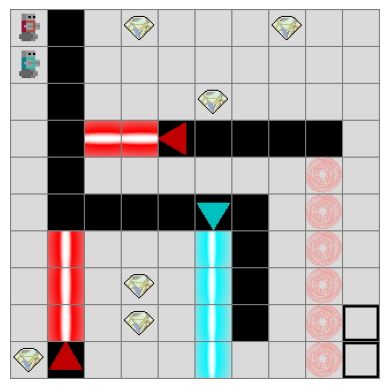

Available actions: [[Stay], [Stay, South]]


In [35]:
display_world(world)
print("Available actions:", world.available_actions())

See how those actions change when we make a step:

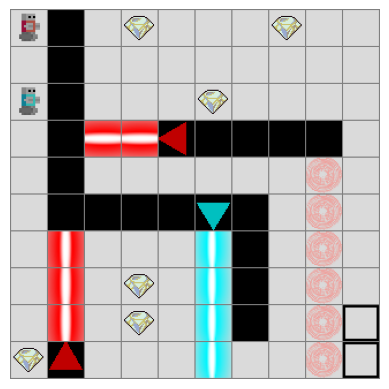

Available actions: [[Stay, South], [Stay, North, South]]


In [36]:
world.step([Action.STAY, Action.SOUTH])
display_world(world)
print("Available actions:", world.available_actions())

But see how some actions are not combinable: if we ask for two agents to reach the same tile, they do not move.

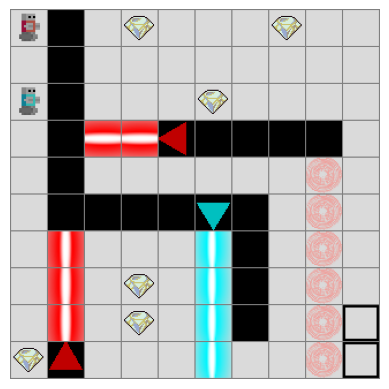

In [38]:
world.step([Action.SOUTH, Action.NORTH])
display_world(world)

## 4. Conclusion
In this notebook, we have seen how to design a `lle` problem, and we have shown how to interact with agents. We have defined the problem of solving such defined environments.